## CNN

* https://paper.dropbox.com/doc/CNN-ZJvbCzAnDTYe71NH60HRI

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/bfortuner/workplace/VisionQuest")
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

torch.Size([128, 1, 28, 28])


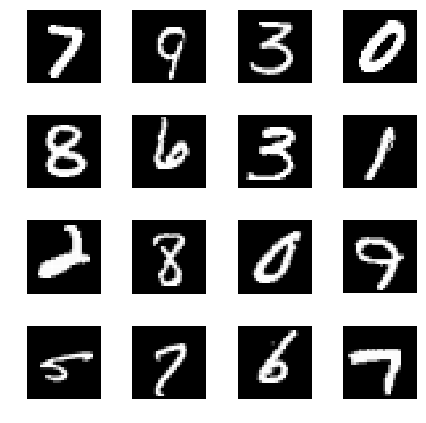

In [10]:
# MNIST
train_loader, test_loader = datasets.get_mnist_loader()
inputs,targets = next(iter(train_loader))
print(inputs.size())
utils.imgs.plot_bw_samples(inputs)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


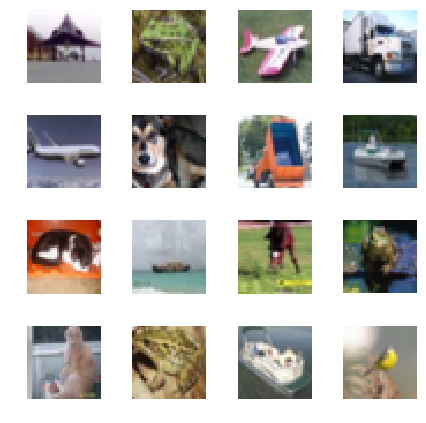

In [9]:
# CIFAR
train_loader, test_loader, classes = datasets.get_cifar_loader()
inputs,targets = next(iter(train_loader))
print(inputs.size())
utils.imgs.plot_rgb_samples(inputs)

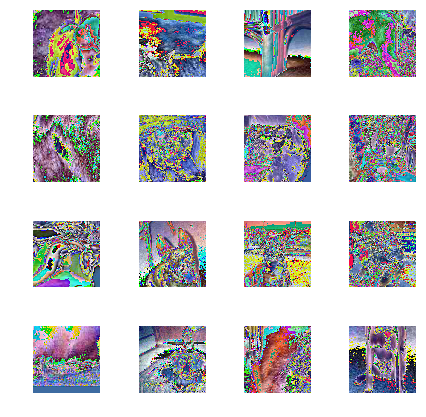

In [8]:
# Cats/Dogs
# IMG_DIR = '/bigguy/data/dogscats/train/'
# train_loader, test_loader, classes = datasets.get_catsdogs_loader(IMG_DIR)
# inputs,targets,img_paths = next(iter(train_loader))
# utils.imgs.plot_rgb_samples(inputs)

## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        n_pool = 3
        w = int(w / 2**n_pool)
        h = int(h / 2**n_pool)
        self.features = nn.Sequential(
            nn.Conv2d(c, 8, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*w*h, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Train

In [ ]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()

In [ ]:
inputs,targets = next(iter(train_loader))
output = model(Variable(inputs.cuda()))
output.size()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
lr_adjuster = learning_rates.FixedLR(initial_lr=1e-3, iteration_type='epoch')
trainer = training.QuickTrainer()
trainer.run(model, train_loader, test_loader, criterion, optimizer, epochs=10) 

In [ ]:
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']],1))

## Sources